<a href="https://colab.research.google.com/github/igorpereirabr1/Colaboratory/blob/master/Keras_Transfer_Learning_Xception_Dog_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 00 - Objective

Implement a CNN based on transfer learning Xception model with Keras and Tensorflow to predict Dogs or Cats at images.

# 01- Mount Directory and Define project Path

In [32]:

import os
import sys
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

project_path = "/content/gdrive/My Drive/01-DataScience/01-Deep Learning/01-Keras/00-CNN"

dataset_path = "/content/gdrive/My Drive/01-DataScience/01-Deep Learning/00-Datasets"



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 03 -Importing Libraries and Splitting the Dataset

In [2]:
# save the final model to file
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import History
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
 
# define cnn model
def define_model():
	# load model
	model = Xception(include_top=False,weights='imagenet', input_shape=(299, 299, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(299, 299))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 299, 299, 3)
    # center pixel data
    img = img.astype('float32')
    return img
 

Using TensorFlow backend.


# 5 - Split the Dataset

In [5]:
from keras.preprocessing.image import ImageDataGenerator, load_img

#set the new dataset path

dataset_path='/content/gdrive/My Drive/01-DataScience/01-Deep Learning/00-Datasets'

dataset_path = os.path.join(dataset_path,'PetImages')

#For this case, we don't need use Data Augmentation, cause we have a big dataset
datagen = ImageDataGenerator(rescale=1./255
                                   ,validation_split=0.33,data_format='channels_last'
        ,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)


training_set = datagen.flow_from_directory(
        directory=dataset_path,
        target_size=(299, 299),
        batch_size=64,
        #classes=['Dog','Cat'],
        subset = "training",
        #save_to_dir = os.path.join(dataset_path,'train'),
        class_mode='binary')

test_set = datagen.flow_from_directory(
       directory=dataset_path,
        target_size=(299, 299),
        batch_size=64,
        #classes=['Dog','Cat'],
        subset = "validation",
        #save_to_dir = os.path.join(dataset_path,'test'),
        class_mode='binary')

STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=test_set.n//test_set.batch_size

Found 16749 images belonging to 2 classes.
Found 8248 images belonging to 2 classes.


# 6 - Training CNN

In [0]:
classifier = define_model()

history = History()
epochs = 15

classifier.fit_generator(training_set,steps_per_epoch=STEP_SIZE_TRAIN,epochs=epochs,validation_data=test_set,validation_steps=STEP_SIZE_VALID,callbacks=[history])

In [0]:
#Save the Model and Weights
import json 
# serialize model to JSON
model_json = classifier.to_json()
with open(os.path.join(project_path,"Keras -Xception-weights_v3.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights(os.path.join(project_path,"Keras -Xception-weights_v3.h5"))
print("Saved model to disk")












# Evaluate out model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [0]:
	# evaluate model
	_, acc = classifier.evaluate_generator(training_set,steps_per_epoch=STEP_SIZE_TRAIN, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255
  ,validation_split=0.01)


validation_set = validation_datagen.flow_from_directory(
       directory=dataset_path,
        shuffle=False,
        target_size=(299, 299),
        batch_size=64,
        subset = "validation",
        class_mode='binary')

STEP_SIZE_VALID=validation_set.n//validation_set.batch_size






Found 248 images belonging to 2 classes.


In [8]:
import json


# load json and create model
json_file = open(os.path.join(project_path,"Keras -Xception-weights_v3.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = model_from_json(loaded_model_json)
# load weights into new model
classifier.load_weights(os.path.join(project_path,"Keras -Xception-weights_v3.h5"))
print("Loaded model from disk")
 
# evaluate loaded model on test data
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

predictions = classifier.predict_generator(validation_set, steps=len(validation_set))

loss, acc = classifier.evaluate_generator(validation_set, steps=len(validation_set))

print(" The Accuracy for this model is :"+str(acc), " and the Loss is it "+str(loss))




Loaded model from disk
 The Accuracy for this model is :0.9637096754966243  and the Loss is it 0.13657298995061748


In [0]:
classe_map = validation_set.class_indices

threshold = 0.5

df = pd.DataFrame()


df['labels'] = validation_set.labels
df['filepaths'] = validation_set.filepaths
df['filename'] = validation_set.filenames
df['name'] = [str(k).split('/')[0] for k in validation_set.filenames]

df['probability'] = predictions
df['category'] = np.where(df['probability'] > threshold, 1,0)
df['category_name'] = df['category'].apply(lambda x: list(classe_map.keys())[list(classe_map.values()).index(x)])



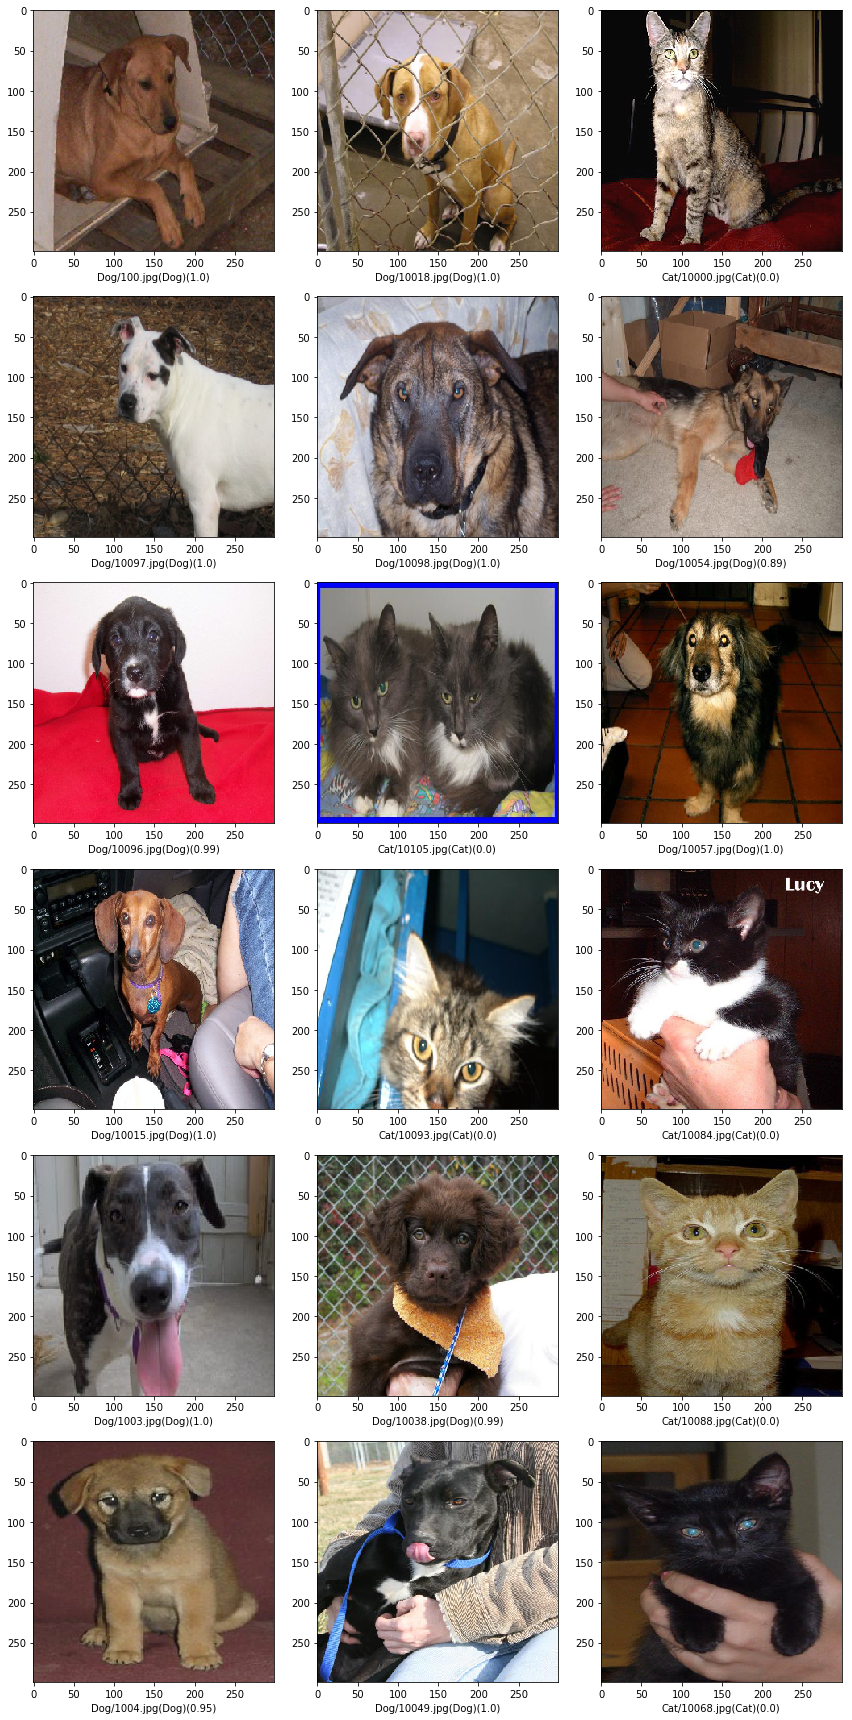

In [20]:
IMAGE_SIZE = validation_set.image_shape[:-1]


sample_test = df.sample(n=18)
sample_test.head()
plt.figure(figsize=(12, 24))
index =0
for x, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category_name']
    probability = row['probability']
    file_path = row['filepaths']
    img = load_img(file_path, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    index +=1
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

# Novas Imagens

In [33]:

new_datagen = ImageDataGenerator(rescale=1./255)
new_generator.reset()
new_generator = new_datagen.flow_from_directory(
       "./gdrive/My Drive/new_images/",
        target_size=(299, 299),
        batch_size=64,
        class_mode='binary',
        shuffle=False)

new_predictions = classifier.predict_generator(new_generator,len(new_generator))

Found 42 images belonging to 1 classes.


In [0]:
classe_map = validation_set.class_indices

threshold = 0.5

df_new = pd.DataFrame()


df_new['labels'] = new_generator.labels
df_new['filepaths'] = new_generator.filepaths
df_new['filename'] = new_generator.filenames
df_new['name'] = [str(k).split('/')[0] for k in new_generator.filenames]

df_new['probability'] = new_predictions
df_new['category'] = np.where(df_new['probability'] > threshold, 1,0)
df_new['category_name'] = df_new['category'].apply(lambda x: list(classe_map.keys())[list(classe_map.values()).index(x)])


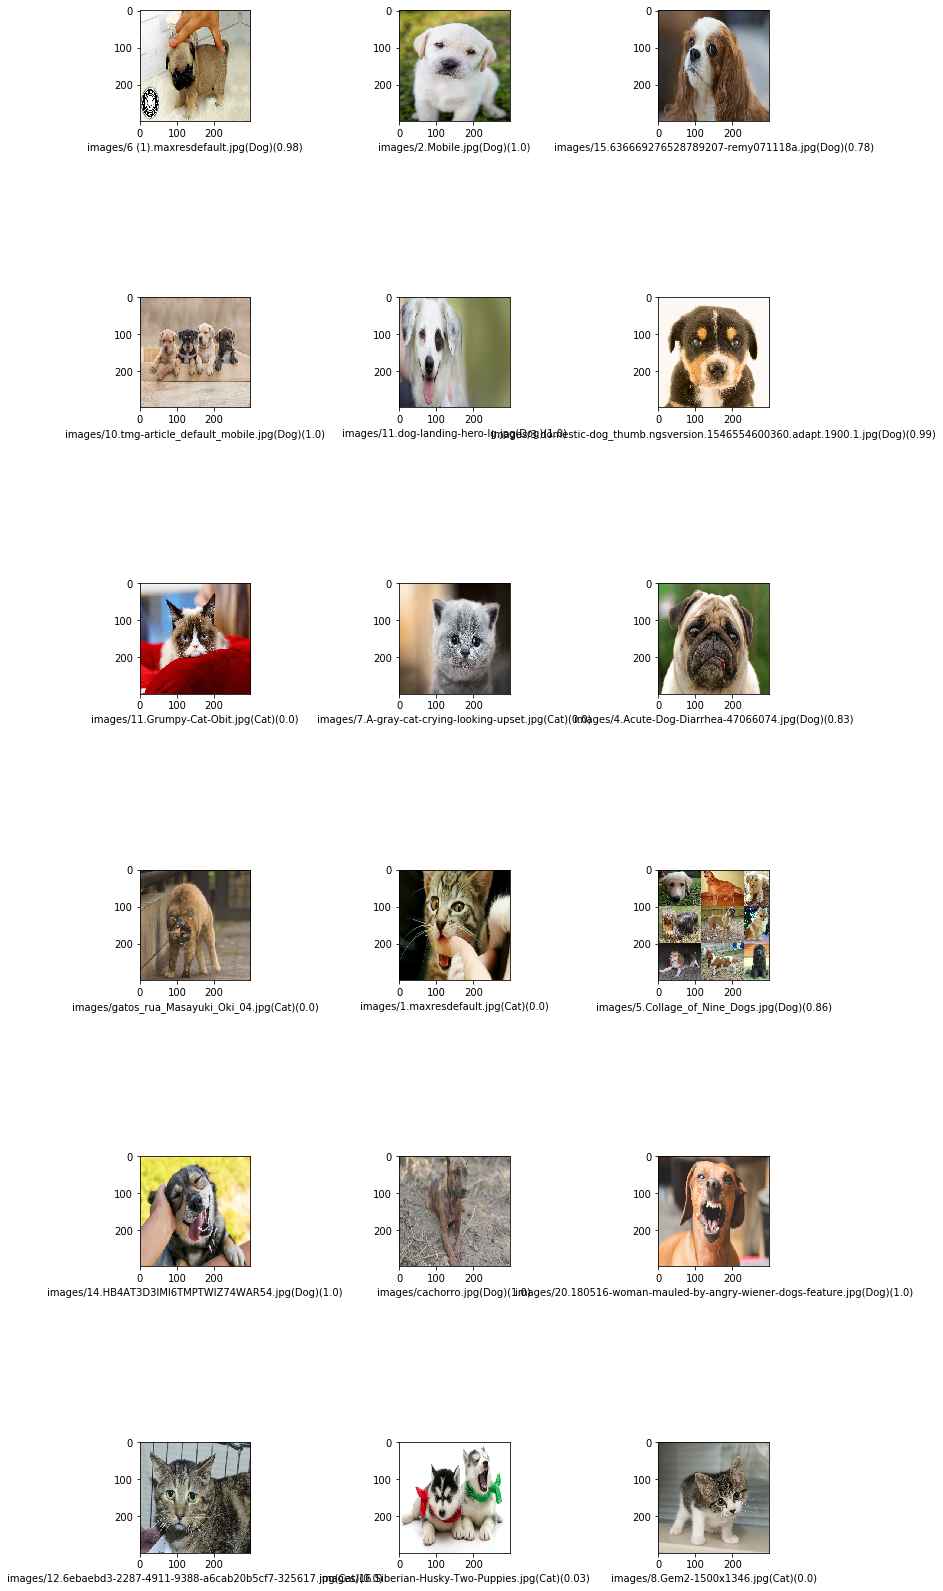

In [35]:
IMAGE_SIZE = new_generator.image_shape[:-1]

test = df_new.sample(n=min(18,len(new_generator.filenames)))
test.head()
plt.figure(figsize=(12, 24))
index =0
for x, row in test.iterrows():
    filename = row['filename']
    category = row['category_name']
    probability = row['probability']
    file_path = row['filepaths']
    img = load_img(file_path, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    index +=1
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

In [21]:
!pip install google_images_download

     |████████████████████████████████| 911kB 38.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
from google_images_download import google_images_download   #importing the library

response = google_images_download.googleimagesdownload()   #class instantiation

arguments = {"keywords":"Dog","limit":100,"print_urls":False,"output_directory":"gdrive/My Drive/new_images/images/","no_directory":True,"prefix":"dog"}   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function
print(paths)

IOError on an image...trying next one... Error: The read operation timed out
Completed Image ====> dog 20.maxresdefault.jpg
Completed Image ====> dog 21.shark-bait-dogs.jpg
Completed Image ====> dog 22.Adler-1-600x600.png
Completed Image ====> dog 23.Lab_hpMain_16x9_992.jpg
Completed Image ====> dog 24.14-a-dogs-way-home.w700.h700.jpg
Invalid or missing image format. Skipping...
Completed Image ====> dog 25.cocker-spaniel.jpg
Completed Image ====> dog 26.Ace-1-600x600.png
Completed Image ====> dog 27.NHS-Slider-03-1024x731.jpg
Completed Image ====> dog 28.180516-woman-mauled-by-angry-wiener-dogs-feature.jpg
Completed Image ====> dog 29.giphy.gif
Completed Image ====> dog 30.merlin_140144286_193276f3-89e9-44a8-a828-51ec9ff5bc8e-articleLarge.jpg
Completed Image ====> dog 31.scroll001.jpg
Invalid or missing image format. Skipping...
Completed Image ====> dog 32.shot-of-a-dog.jpg
Completed Image ====> dog 33.housetrain_adult_dog_hero.jpg
Completed Image ====> dog 34.636669276528789207-remy

In [0]:
path = "gdrive/My Drive/new_images/images/"


i = 0

for filename in os.listdir(path): 
    dst = filename[:3]+str("_") + str(i) + ".jpg"
    src =path + filename 
    dst =path+ dst 

    # rename() function will 
    # rename all the files 
    os.rename(src, dst) 
    i += 1

In [45]:
os.listdir("gdrive/My Drive/new_images/images/")[0][:3]

'cat'